In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import BCELoss
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import time
import copy

In [ ]:
#Read merged data set
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AFD/merged_compustat_and_labels.csv')

In [ ]:
#Preprocess dataset
df = df.fillna(0)

df = df[df.columns].replace([np.inf, -np.inf], 0)

columns_to_normalize = ['act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib',
                       'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk',
                       'txp', 'txt', 'xint', 'prcc_f', 'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets',
                       'ch_cs', 'ch_cm', 'ch_roa', 'bm', 'dpi', 'reoa', 'EBIT', 'ch_fcf', 'issue']

#Step 2: Apply Min-Max scaling for normalization
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Step 3: Convert the normalized values to float type (should already be in float)
df[columns_to_normalize] = df[columns_to_normalize].astype('float32')

In [ ]:
desired_columns_order = [
    'gvkey', 'fyear', 'tic', 'cik', 'Bank', 'act', 'ap', 'at', 'ceq', 'che',
    'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib', 'invt', 'ivao', 'ivst',
    'lct', 'lt', 'ni', 'ppegt', 'ppent', 'pstk', 're', 'rect', 'sale', 'sstk',
    'txp', 'txt', 'xint', 'prcc_f', 'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv',
    'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'issue', 'bm', 'dpi', 'reoa',
    'EBIT', 'ch_fcf', 'misstate']

# Reorder the columns
df = df.reindex(columns=desired_columns_order)

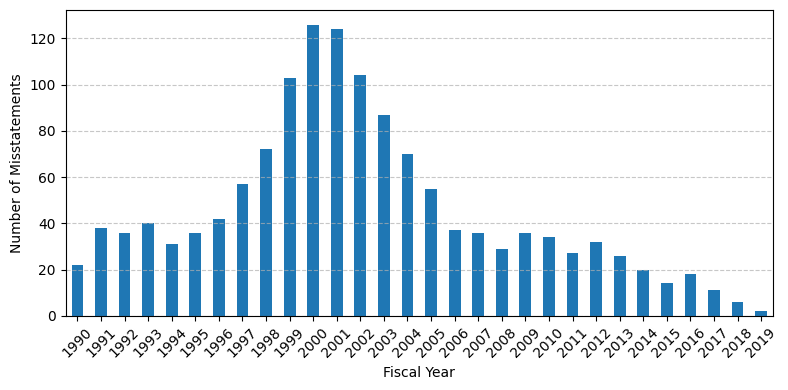

Total number of misstatements from 1990 to 2019: 1371
Total number of misstatements in the training period from 1990 to 2002: 831
Total number of misstatements in the testing period from 2003 to 2019: 540


In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame for years from 1990 to 2019
filtered_df = df[(df['fyear'] >= 1990) & (df['fyear'] <= 2019)]
training_df = df[(df['fyear'] >= 1990) & (df['fyear'] <= 2002)]
testing_df = df[(df['fyear'] >= 2003) & (df['fyear'] <= 2019)]

# Group by fiscal year and sum misstatements
misstatements_by_fyear = filtered_df.groupby('fyear')['misstate'].sum()
misstatements_by_fyear_training = training_df.groupby('fyear')['misstate'].sum()
misstatements_by_fyear_testing = testing_df.groupby('fyear')['misstate'].sum()

# Calculate total misstatements
total_misstatements = misstatements_by_fyear.sum()
total_misstatements_training = misstatements_by_fyear_training.sum()
total_misstatements_testing = misstatements_by_fyear_testing.sum()

# Plotting
plt.figure(figsize=(8, 4))
misstatements_by_fyear.plot(kind='bar')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Misstatements')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print total misstatements
print("Total number of misstatements from 1990 to 2019:", total_misstatements)
print("Total number of misstatements in the training period from 1990 to 2002:", total_misstatements_training)
print("Total number of misstatements in the testing period from 2003 to 2019:", total_misstatements_testing)

In [ ]:
# Split features into the specified groups
raw_items_28_financial_ratios_14 = ['act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib',
                       'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk',
                       'txp', 'txt', 'xint','prcc_f', 'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets',
                       'ch_cs', 'ch_cm', 'ch_roa', 'bm', 'dpi', 'reoa', 'EBIT', 'ch_fcf', 'issue']


In [ ]:
# Assign Train, Val, and Test periods
train_period, test_period = (1990, 2002), (2003, 2019)

# loading data
train_data = df[(df['fyear'] >= train_period[0]) & (df['fyear'] <= train_period[1])]
test_data = df[(df['fyear'] >= test_period[0]) & (df['fyear'] <= test_period[1])]

# Extract features (X) and target variable (y) for training and testing
X_train = train_data[raw_items_28_financial_ratios_14]
y_train = train_data['misstate']

X_test = test_data[raw_items_28_financial_ratios_14]
y_test = test_data['misstate']

# Undersampling the data
rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("Training data Shape after under sampling:", X_train_resampled.shape, y_train_resampled.shape)

Training data Shape after under sampling: (1662, 42) (1662,)


In [ ]:
financial_ratios_14 = ['dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'bm',
                          'dpi', 'reoa', 'EBIT', 'ch_fcf', 'issue']

raw_financial_items_28 = ['act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib',
                       'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk',
                       'txp', 'txt', 'xint', 'prcc_f']

X_train_resampled_28 = X_train_resampled.loc[:, raw_financial_items_28]
y_train_resampled_28 = y_train_resampled

X_test_28 = X_test.loc[:, raw_financial_items_28]
y_test_28 = y_test

X_train_resampled_14 = X_train_resampled.loc[:, financial_ratios_14]
y_train_resampled_14 = y_train_resampled

X_test_14 = X_test.loc[:, financial_ratios_14]
y_test_14 = y_test

In [ ]:
merged_train_data = pd.concat([X_train_resampled, y_train_resampled], axis = 1)
merged_test_data = pd.concat([X_test, y_test], axis = 1)

merged_train_data_28 = pd.concat([X_train_resampled_28, y_train_resampled_28], axis = 1)
merged_test_data_28 = pd.concat([X_test_28, y_test_28], axis = 1)

merged_train_data_14 = pd.concat([X_train_resampled_14, y_train_resampled_14], axis = 1)
merged_test_data_14 = pd.concat([X_test_14, y_test_14], axis = 1)

In [ ]:
merged_train_data.to_csv('/content/drive/MyDrive/Colab Notebooks/AFD/merged_train_data.csv', index=False)
merged_test_data.to_csv('/content/drive/MyDrive/Colab Notebooks/AFD/merged_test_data.csv', index=False)

merged_train_data_28.to_csv('/content/drive/MyDrive/Colab Notebooks/AFD/merged_train_data_28.csv', index=False)
merged_test_data_28.to_csv('/content/drive/MyDrive/Colab Notebooks/AFD/merged_test_data_28.csv', index=False)

merged_train_data_14.to_csv('/content/drive/MyDrive/Colab Notebooks/AFD/merged_train_data_14.csv', index=False)
merged_test_data_14.to_csv('/content/drive/MyDrive/Colab Notebooks/AFD/merged_test_data_14.csv', index=False)

In [ ]:
class CSVDataset(Dataset):
    #Constructor for initially loading
    def __init__(self, path):
        df = read_csv(path, header=0)
        self.X = df.values[0:, :-1]
        self.y = df.values[0:, -1]
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))

        print(self.X.shape)
        print(self.y.shape)

    # Get the number of rows in the dataset
    def __len__(self):
        return len(self.X)
    # Get a row at an index
    def __getitem__(self,idx):
        return [self.X[idx], self.y[idx]]

In [ ]:
def prepare_train_dataset(path):
    train = CSVDataset(path)
    train_dl = DataLoader(train, batch_size=1662, shuffle=True)
    return train_dl

def prepare_test_dataset(path):
    test = CSVDataset(path)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return test_dl


In [ ]:
train_dl_42 = prepare_train_dataset('/content/drive/MyDrive/Colab Notebooks/AFD/merged_train_data.csv')
test_dl_42 = prepare_test_dataset('/content/drive/MyDrive/Colab Notebooks/AFD/merged_test_data.csv')

train_dl_28 = prepare_train_dataset('/content/drive/MyDrive/Colab Notebooks/AFD/merged_train_data_28.csv')
test_dl_28 = prepare_test_dataset('/content/drive/MyDrive/Colab Notebooks/AFD/merged_test_data_28.csv')

train_dl_14 = prepare_train_dataset('/content/drive/MyDrive/Colab Notebooks/AFD/merged_train_data_14.csv')
test_dl_14 = prepare_test_dataset('/content/drive/MyDrive/Colab Notebooks/AFD/merged_test_data_14.csv')

(1662, 42)
(1662, 1)
(125314, 42)
(125314, 1)
(1662, 28)
(1662, 1)
(125314, 28)
(125314, 1)
(1662, 14)
(1662, 1)
(125314, 14)
(125314, 1)


In [ ]:
#{'n_layers': 5, 'layer_0_size': 57, 'layer_1_size': 22, 'layer_2_size': 107, 'layer_3_size': 202, 'layer_4_size': 162,
#'activation_0': 'relu', 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'sigmoid', 'activation_4': 'sigmoid'}.

class FraudDetectionMLP(Module):
    def __init__(self, n_inputs):
        super(FraudDetectionMLP, self).__init__()
        # Input layer
        self.hidden1 = Linear(n_inputs, 57)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # Second (hidden) layer
        self.hidden2 = Linear(57, 22)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # Third (hidden) layer
        self.hidden3 = Linear(22, 107)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # Fourth (hidden) layer
        self.hidden4 = Linear(107, 202)
        kaiming_uniform_(self.hidden4.weight, nonlinearity='relu')
        self.act4 = Sigmoid()
        # Fifth (hidden) layer
        self.hidden5 = Linear(202, 162)
        kaiming_uniform_(self.hidden5.weight, nonlinearity='relu')
        self.act5 = Sigmoid()
        # Output layer
        self.hidden6 = Linear(162,1)
        xavier_uniform_(self.hidden6.weight)
        self.act6 = Sigmoid()

    def forward(self, X):
        # Input to the first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # Second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # Third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # Fourth hidden layer
        X = self.hidden4(X)
        X = self.act4(X)
        # Fifth hidden layer
        X = self.hidden5(X)
        X = self.act5(X)
        # Output layer
        X = self.hidden6(X)
        X = self.act6(X)
        return X


In [ ]:
def train_model(model, train_dl, num_epochs):

    # Define loss function and optimizer
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            labels = labels.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dl.dataset)

In [ ]:
def evaluate_model(model, test_dl):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc = roc_auc_score(y_true, y_pred)
    print(f"AUC: {auc:.4f}")

In [ ]:
# 42 features model
model = FraudDetectionMLP(42)

In [ ]:
train_model(model, train_dl_42, num_epochs=150)

In [ ]:
evaluate_model(model, test_dl_42)


In [ ]:
auc_values = []

# Perform 10 training runs
for i in range(10):
    model_42 = FraudDetectionMLP(42)
    train_model(model_42, train_dl_42, num_epochs=150)

    # Evaluate the model
    model_42.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_42:
            outputs = model_42(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc = roc_auc_score(y_true, y_pred)
    auc_values.append(auc)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc:.4f}")

# Calculate the average AUC
average_auc = np.mean(auc_values)
print(f"\nAverage AUC: {average_auc:.4f}")

# Calculate the std AUC
auc_std_dev = np.std(auc_values)
print(f"Standard Deviation of AUC: {auc_std_dev:.4f}")

Run 1: AUC = 0.6240
Run 2: AUC = 0.6053
Run 3: AUC = 0.6114
Run 4: AUC = 0.6428
Run 5: AUC = 0.6155
Run 6: AUC = 0.6112
Run 7: AUC = 0.6179
Run 8: AUC = 0.6169
Run 9: AUC = 0.6331
Run 10: AUC = 0.6237

Average AUC: 0.6202
Standard Deviation of AUC: 0.0106


In [ ]:
# 28 raw financial items model
model_28 = FraudDetectionMLP(28)

In [ ]:
train_model(model_28, train_dl_28, num_epochs=150)

In [ ]:
evaluate_model(model_28, test_dl_28)

In [ ]:
auc_values_28 = []

# Perform 10 training runs
for i in range(10):
    model_28 = FraudDetectionMLP(28)
    train_model(model_28, train_dl_28, num_epochs=150)

    # Evaluate the model
    model_28.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_28:
            outputs = model_28(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc_28 = roc_auc_score(y_true, y_pred)
    auc_values_28.append(auc_28)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc_28:.4f}")

# Calculate the average AUC
average_auc_28 = np.mean(auc_values_28)
print(f"\nAverage AUC: {average_auc_28:.4f}")

# Calculate the std AUC
auc_std_dev_28 = np.std(auc_values_28)
print(f"Standard Deviation of AUC: {auc_std_dev_28:.4f}")

Run 1: AUC = 0.6096
Run 2: AUC = 0.5723
Run 3: AUC = 0.5291
Run 4: AUC = 0.6051
Run 5: AUC = 0.5681
Run 6: AUC = 0.6039
Run 7: AUC = 0.5078
Run 8: AUC = 0.4255
Run 9: AUC = 0.5920
Run 10: AUC = 0.4869

Average AUC: 0.5500
Standard Deviation of AUC: 0.0581


In [ ]:
# 14 financial ratios model
model_14 = FraudDetectionMLP(14)

In [ ]:
train_model(model_14, train_dl_14, num_epochs=150)

In [ ]:
evaluate_model(model_14, test_dl_14)

In [ ]:
auc_values_14 = []

# Perform 10 training runs
for i in range(10):
    model_14 = FraudDetectionMLP(14)
    train_model(model_14, train_dl_14, num_epochs=150)

    # Evaluate the model
    model_14.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_14:
            outputs = model_14(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc_14 = roc_auc_score(y_true, y_pred)
    auc_values_14.append(auc_14)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc_14:.4f}")

# Calculate the average AUC
average_auc_14 = np.mean(auc_values_14)
print(f"\nAverage AUC: {average_auc_14:.4f}")

auc_std_dev_14 = np.std(auc_values_14)
print(f"Standard Deviation of AUC: {auc_std_dev_14:.4f}")

Run 1: AUC = 0.6425
Run 2: AUC = 0.6160
Run 3: AUC = 0.6258
Run 4: AUC = 0.6121
Run 5: AUC = 0.6359
Run 6: AUC = 0.6460
Run 7: AUC = 0.5875
Run 8: AUC = 0.6221
Run 9: AUC = 0.6248
Run 10: AUC = 0.6406

Average AUC: 0.6253
Standard Deviation of AUC: 0.0166
